In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import healpy as hp

In [3]:
from pyshtools.utils import Wigner3j

In [4]:
from scipy import constants
from scipy.stats import norm

In [26]:
rcParams['lines.linewidth'] = 2
    
lsize = 20
rcParams['xtick.labelsize'] = lsize
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 5
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1
rcParams['xtick.bottom'] = True
rcParams['xtick.top'] = True
rcParams['xtick.direction'] = 'in'


rcParams['ytick.labelsize'] = lsize
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 5
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1
rcParams['ytick.left'] = True
rcParams['ytick.right'] = True
rcParams['ytick.direction'] = 'in'


rcParams['legend.fontsize'] = lsize
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = lsize
rcParams['axes.titlesize'] = lsize
figsize(12, 10)

In [5]:
TCMB = 2.7255  # K

In [47]:
nu0 = 2.3e9

In [48]:
def powerlaw(ell, beta):
    plaw = np.zeros(len(ell))
    plaw[ell>1] = (ell[ell>1] / 80.)**beta
    return plaw

In [49]:
def normed_cmb_thermo_units(nu):
    X = constants.h * nu / (constants.k * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

In [50]:
def normed_synch(nu, beta):
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

In [51]:
def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(nu0) / normed_cmb_thermo_units(nu)
    return unit

In [52]:
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2

In [53]:
nside = 128
ells = np.arange(385)

In [54]:
pcls = A_BB * powerlaw(ells, alpha_BB)
sbb = hp.synfast(pcls, nside, verbose=False)

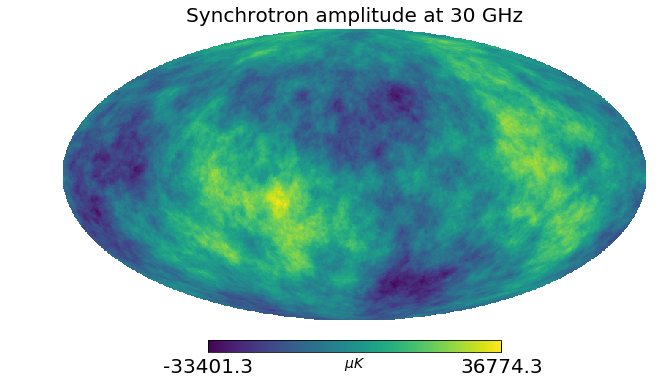

In [55]:
hp.mollview(sbb, unit='$\mu K$', title='Synchrotron amplitude at 30 GHz')

In [56]:
check_cls = hp.anafast(sbb)

Text(0.5, 1.0, 'Synchrotron amplitude power spectrum')

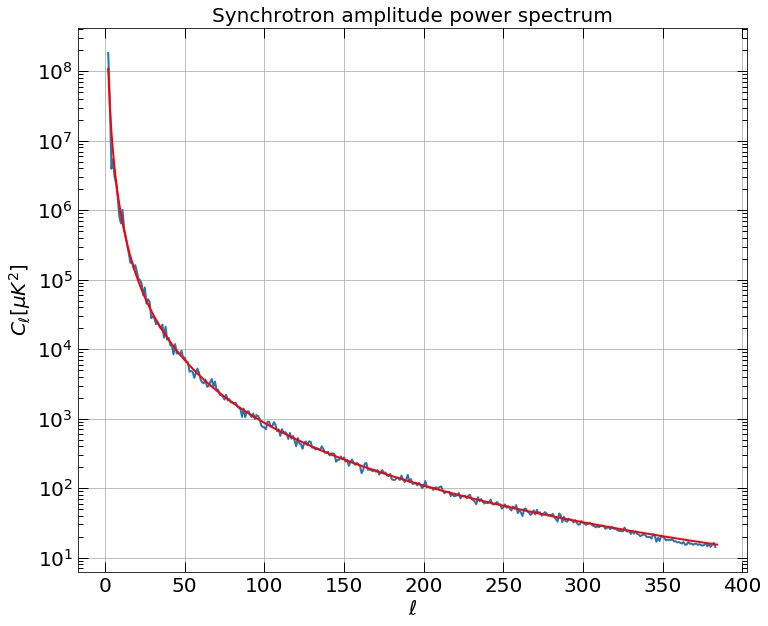

In [65]:
semilogy(ells[2:-1], check_cls[2:])
semilogy(ells[2:], pcls[2:], 'r')
#ylim(1, 1e8)
grid()
ylabel("$C_{\ell} [\mu K^2]$")
xlabel("$\ell$")
title('Synchrotron amplitude power spectrum')

In [66]:
freqs = np.linspace(2.3, 200, 20)*1.e9

In [67]:
sed_scaling = scale_synch(freqs, beta_BB)

(1e-06, 1)

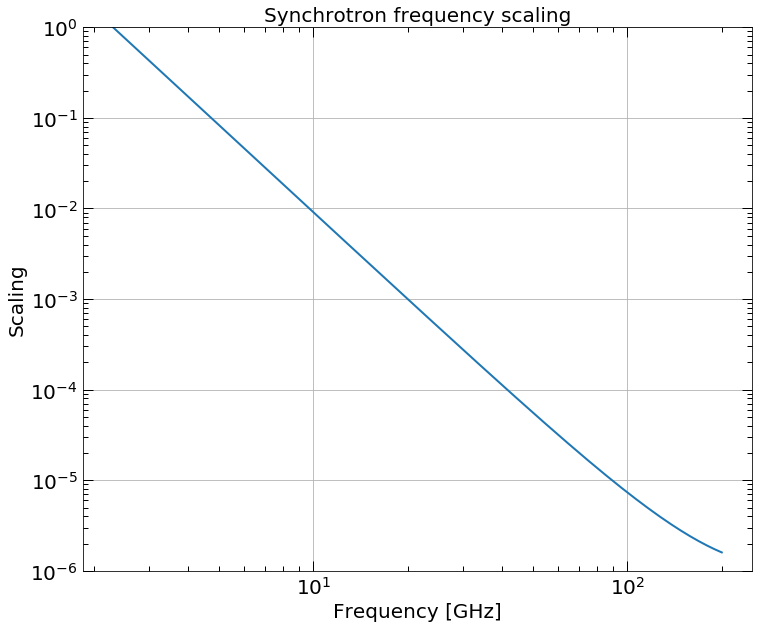

In [69]:
loglog(freqs*1e-9, sed_scaling)
grid()
ylabel('Scaling')
xlabel('Frequency [GHz]')
title('Synchrotron frequency scaling')
ylim(1e-6, 1)

In [70]:
newmaps = (sbb[..., np.newaxis] * sed_scaling).T

In [73]:
gamma_beta = -2.6

In [74]:
beta_cls = 1.5e-6 * powerlaw(ells, gamma_beta)

In [75]:
beta_map = hp.synfast(beta_cls, nside)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [76]:
beta_map -= np.mean(beta_map) + 3.2

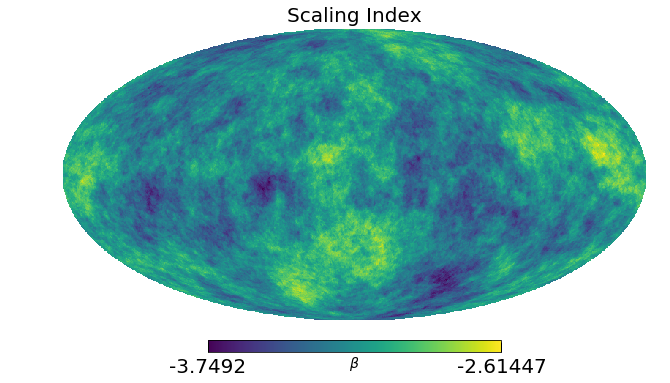

In [79]:
hp.mollview(beta_map, unit='$\\beta$', title='Scaling Index')

In [80]:
check_bcls = hp.anafast(beta_map)

In [85]:
new_sed_scaling = scale_synch(freqs, beta_map)

(1e-06, 1)

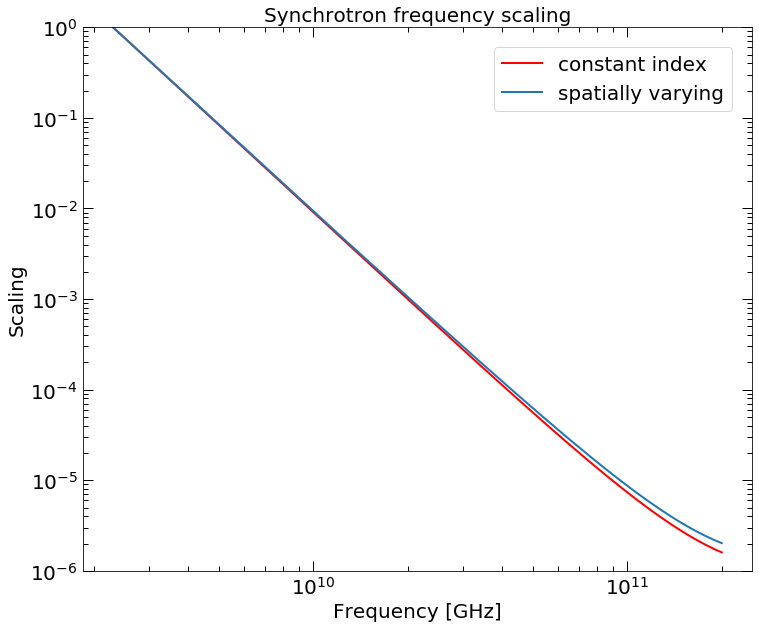

In [89]:
loglog(freqs, sed_scaling, 'r', label='constant index')
loglog(freqs, np.mean(new_sed_scaling, axis=0), label='spatially varying')
ylabel('Scaling')
xlabel('Frequency [GHz]')
title('Synchrotron frequency scaling')
legend()
ylim(1e-6, 1)

In [95]:
x = (sbb[..., np.newaxis] * new_sed_scaling).T

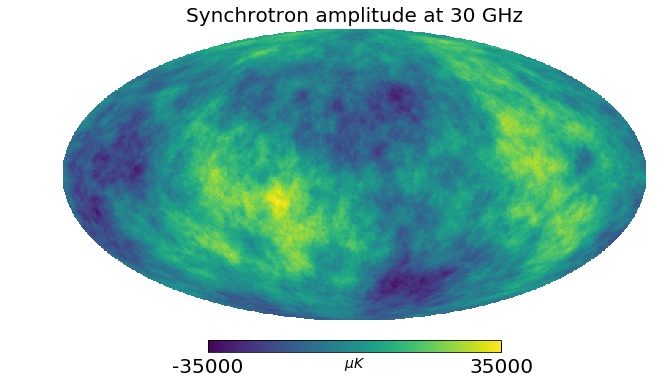

In [110]:
hp.mollview(sbb, unit='$\mu K$', title='Synchrotron amplitude at 30 GHz', min=-35000, max=35000)

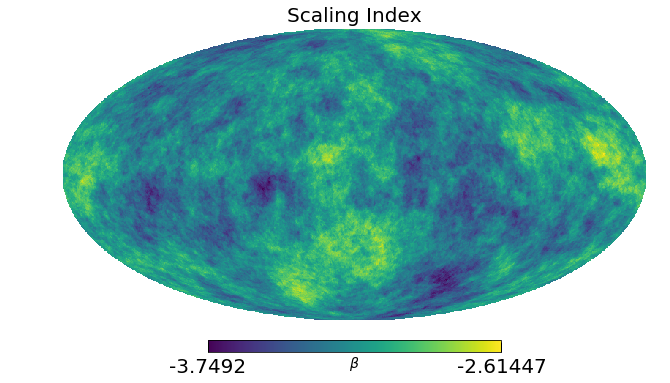

In [120]:
hp.mollview(beta_map, unit='$\\beta$', title='Scaling Index')

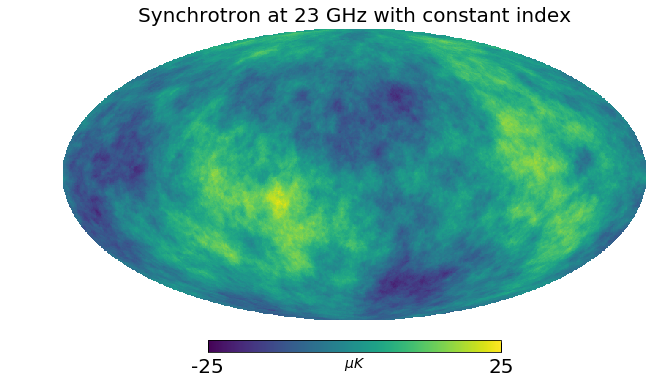

In [111]:
hp.mollview(newmaps[2], unit='$\mu K$', title='Synchrotron at 23 GHz with constant index', min=-25, max=25)

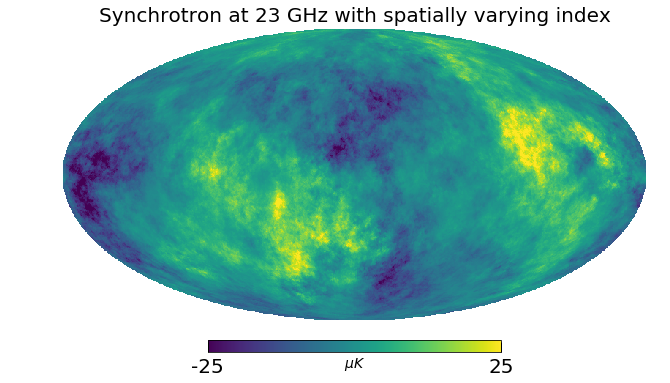

In [112]:
hp.mollview(x[2], unit='$\mu K$', title='Synchrotron at 23 GHz with spatially varying index', min=-25, max=25)

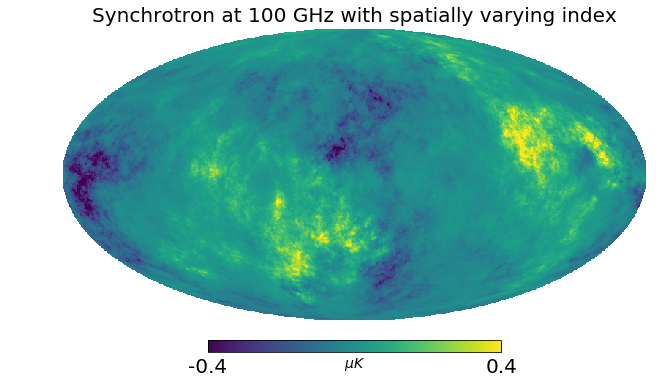

In [119]:
hp.mollview(x[10], unit='$\mu K$', title='Synchrotron at 100 GHz with spatially varying index', min=-0.4, max=0.4)

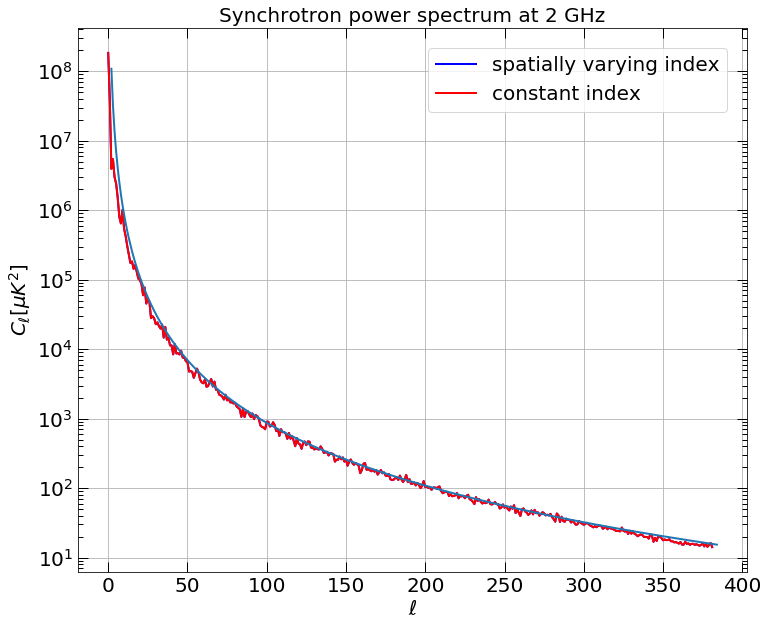

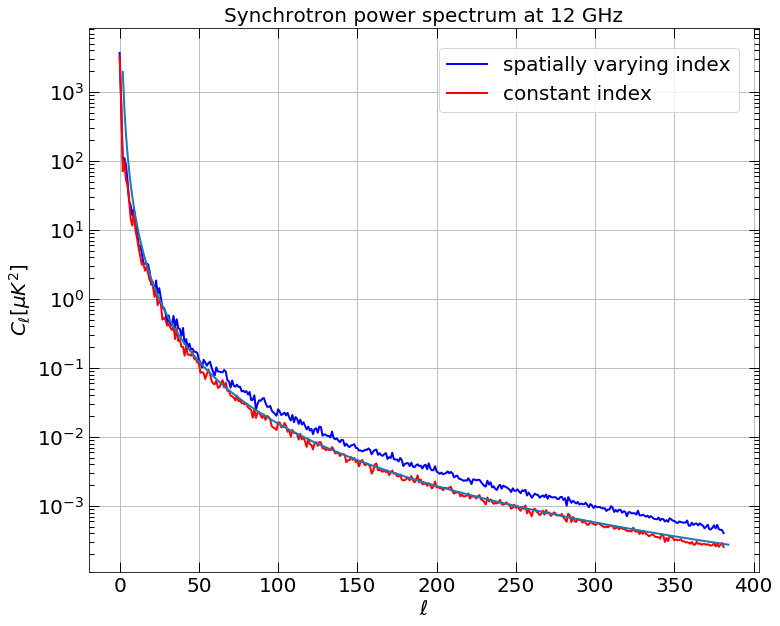

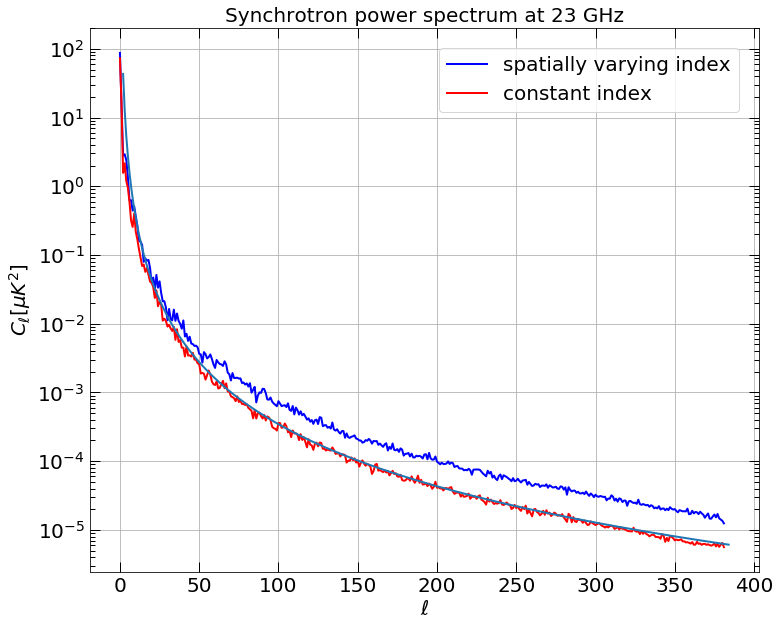

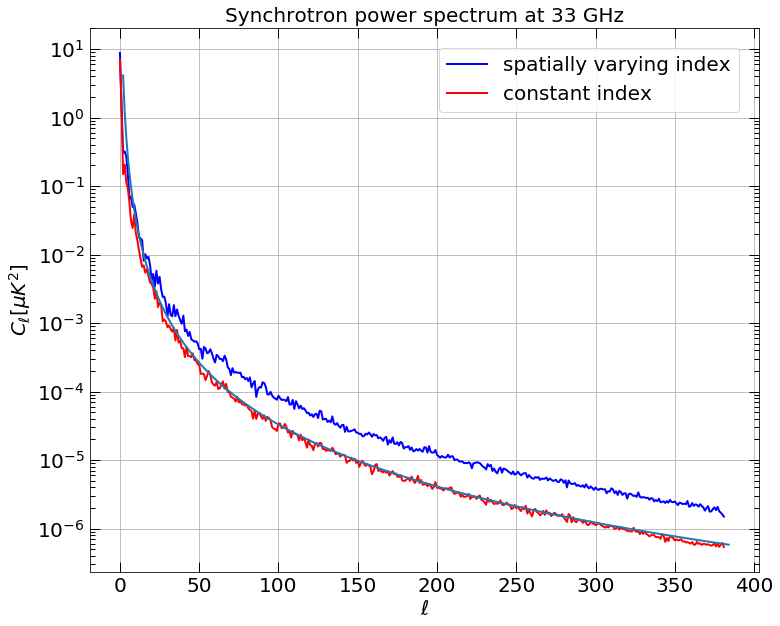

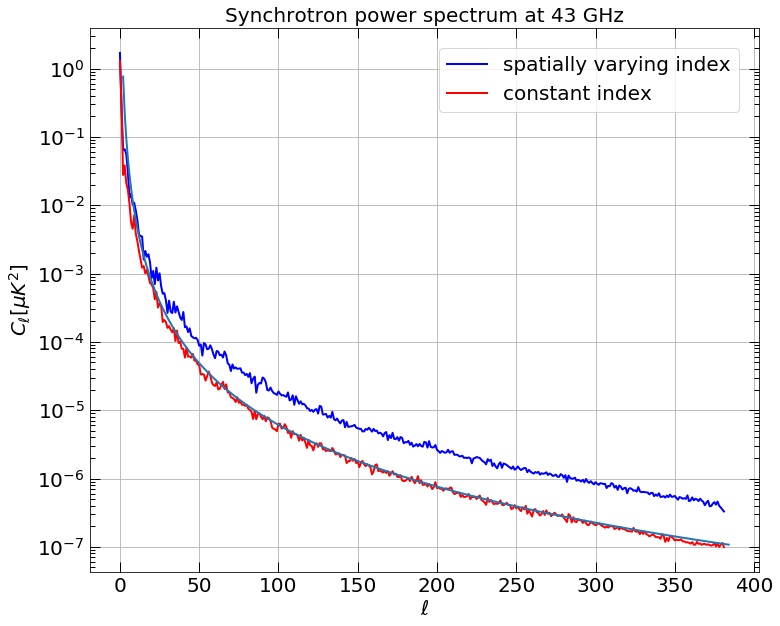

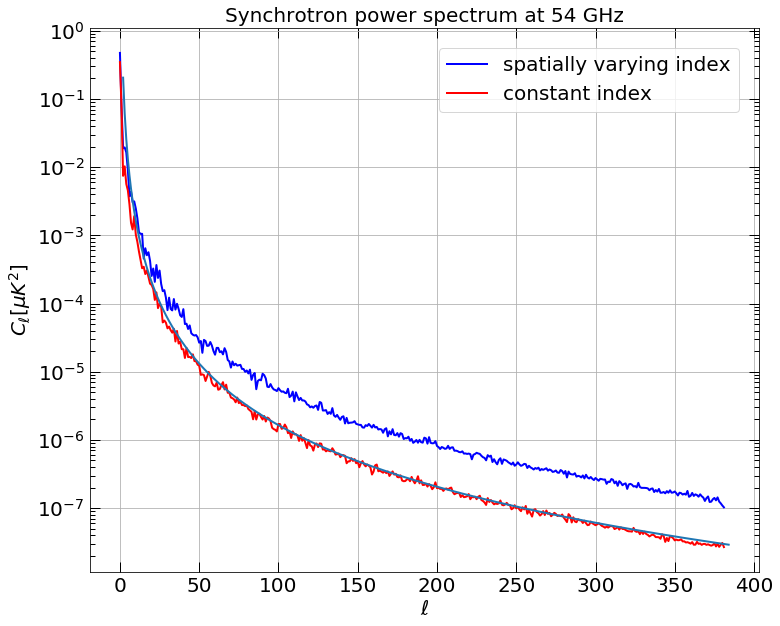

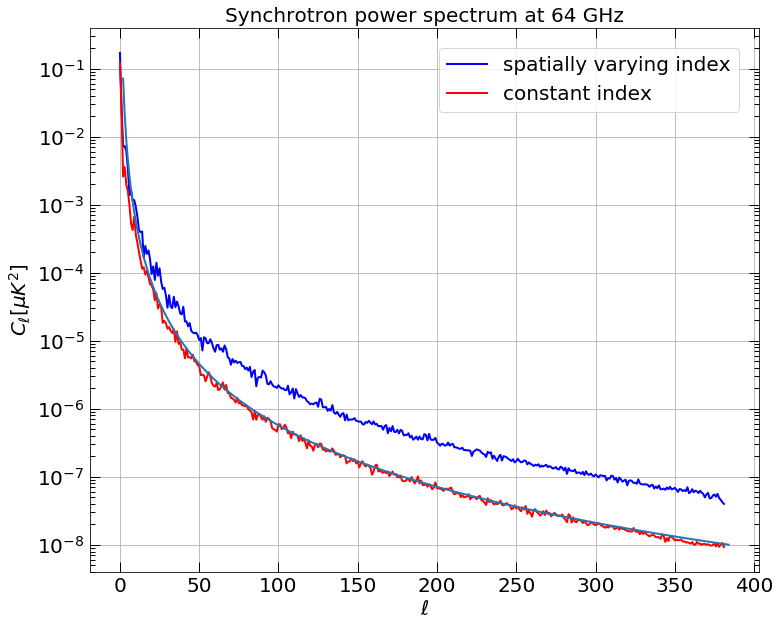

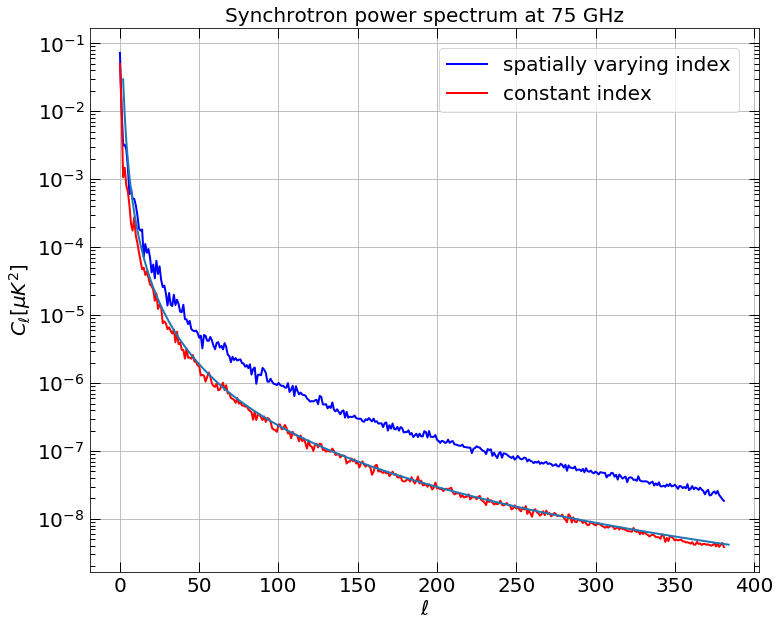

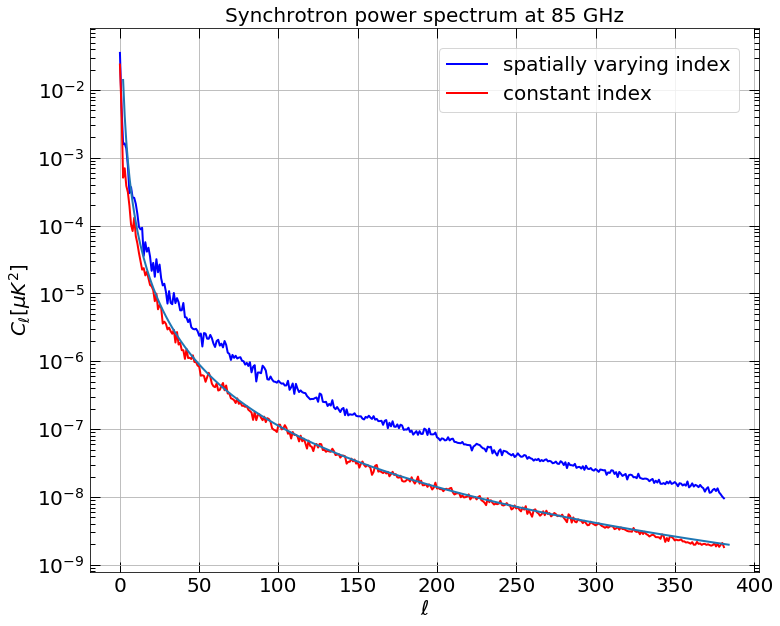

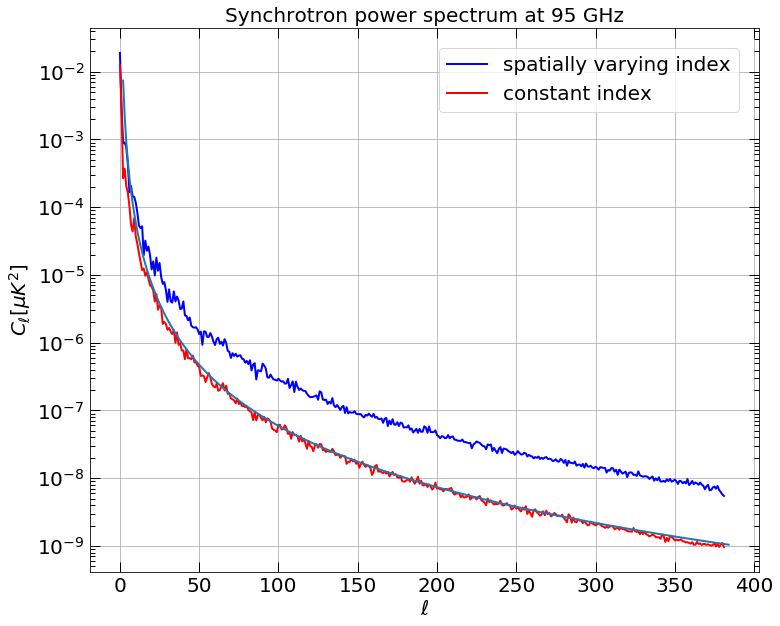

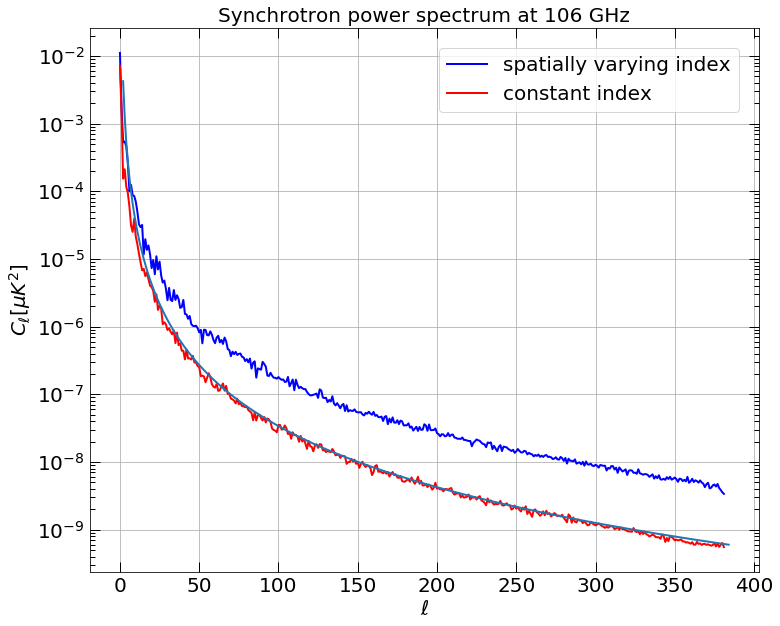

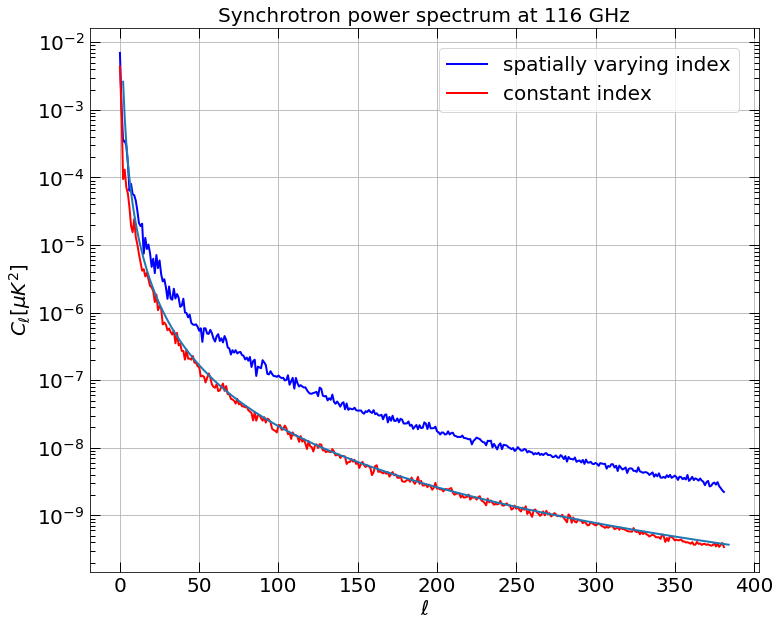

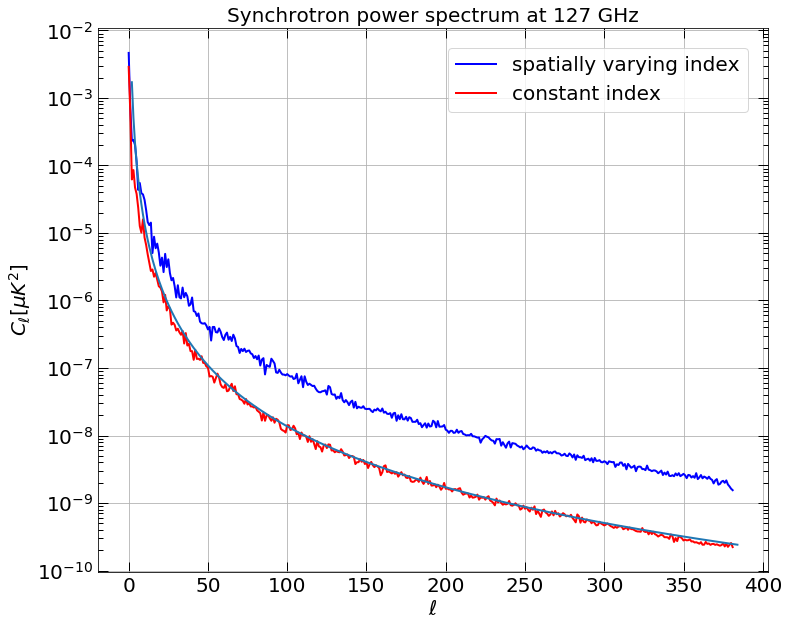

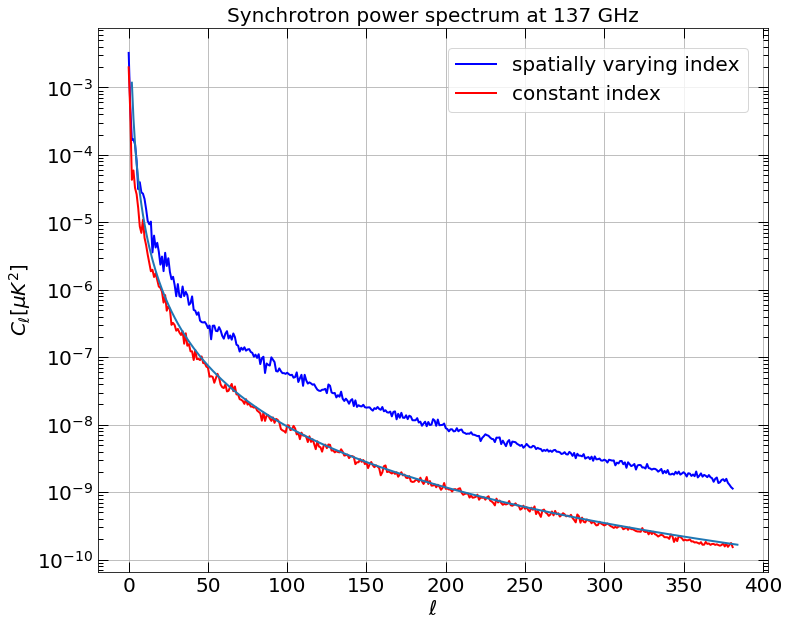

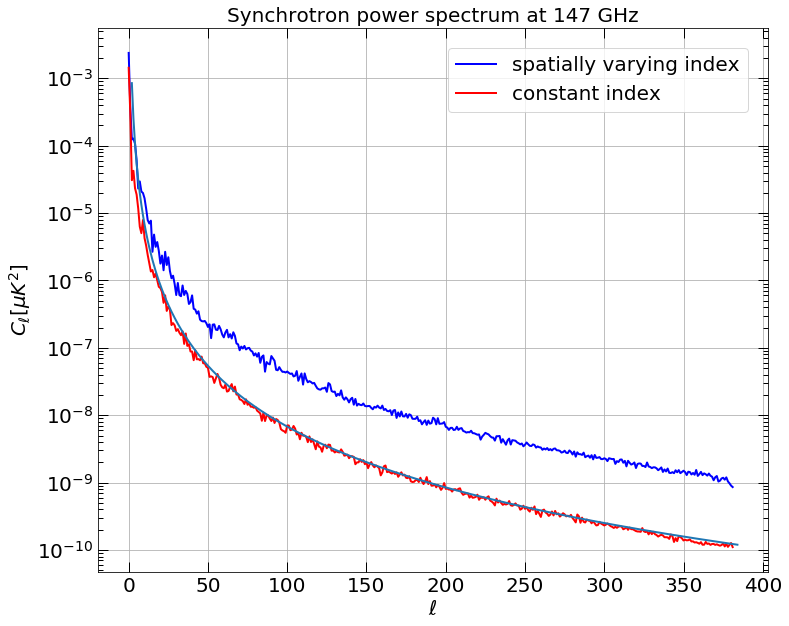

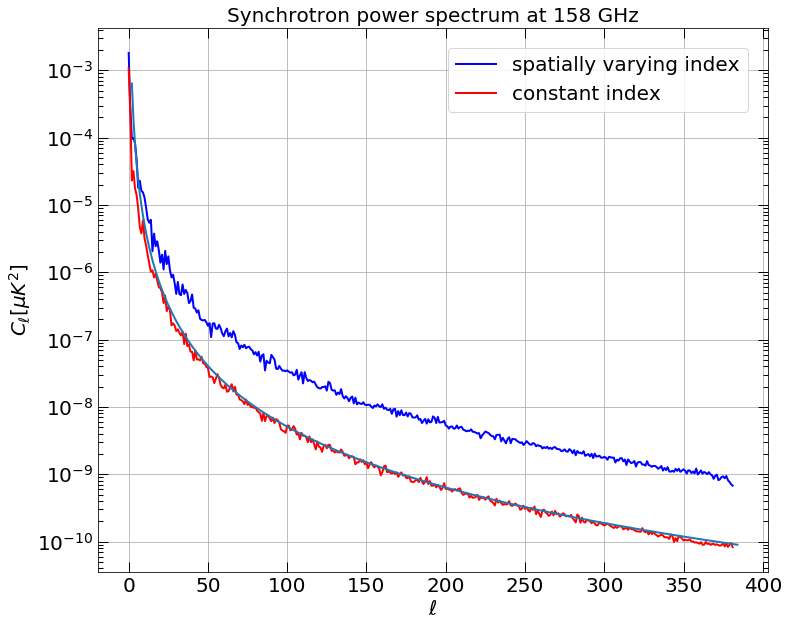

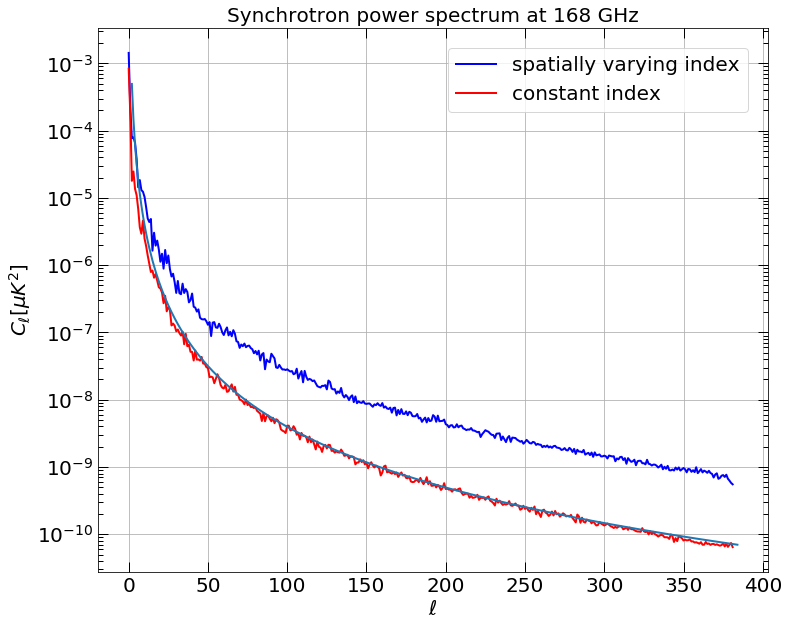

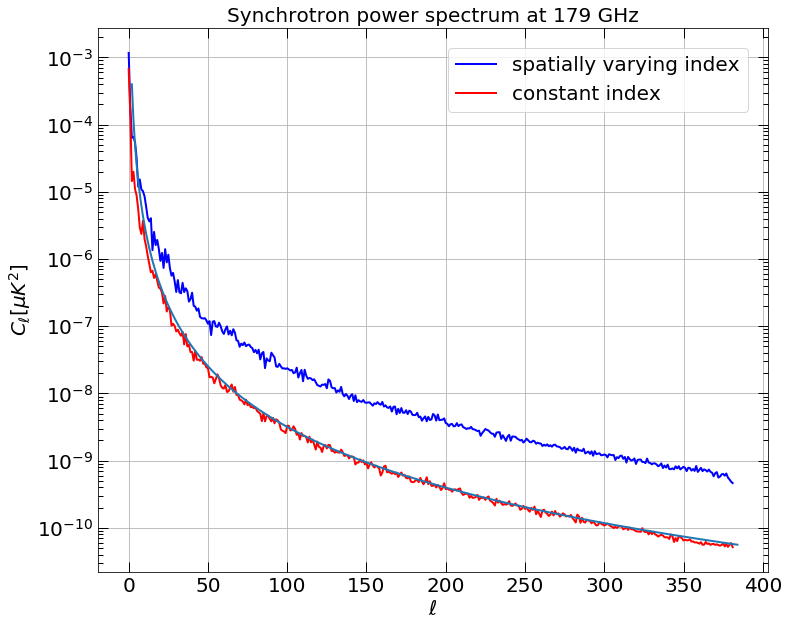

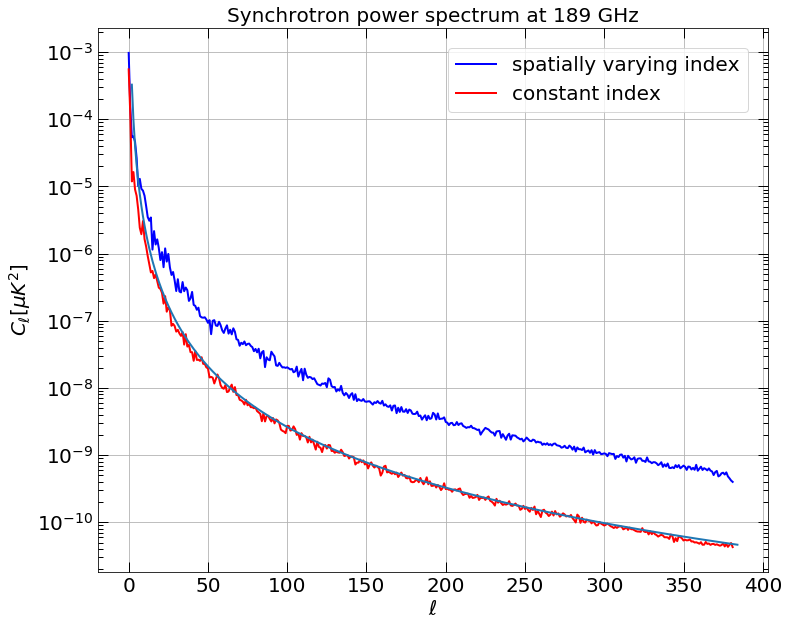

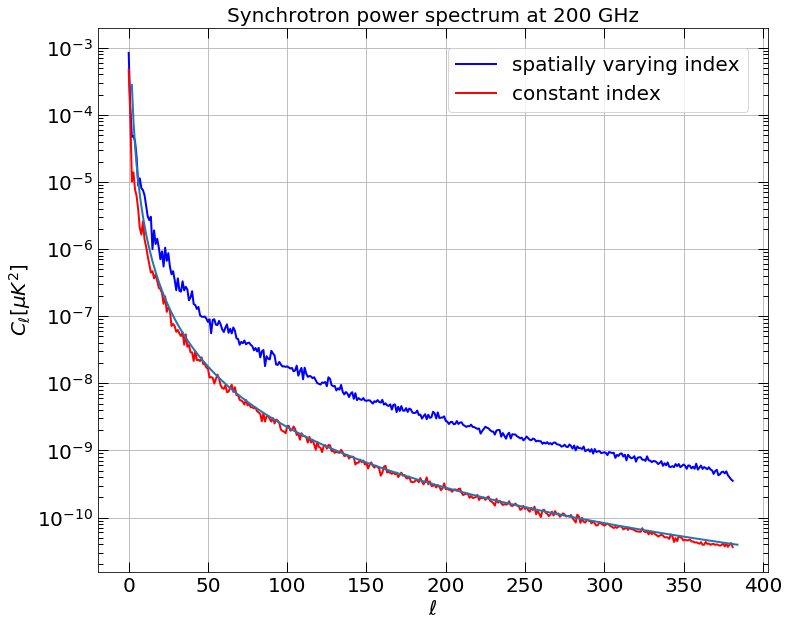

In [128]:
for k in range(20):
    figure()
    newcls = hp.anafast(x[k])
    oldcls = hp.anafast(newmaps[k])
    semilogy(newcls[2:], 'b', label='spatially varying index')
    semilogy(oldcls[2:], 'r', label='constant index')
    semilogy(ells[2:], pcls[2:]*sed_scaling[k]**2)
    grid()
    ylabel("$C_{\ell} [\mu K^2]$")
    xlabel("$\ell$")
    legend()
    title('Synchrotron power spectrum at %d GHz' %int(freqs[k]*1e-9))

In [129]:
def powerlaw(ell, beta):
    if ell < 2:
        return 0.
    return (ell / 80.)**beta

In [130]:
total = np.zeros(800)
for ell1 in ells[1:]:
    for ell2 in ells[1:]:
        w3j, ellmin, ellmax = Wigner3j(ell1, ell2, 0, 0, 0 )
        indexmax = np.where(w3j!=0)[0][-1] + 1
        ellmax += 1
        norm = (2 * ell1 + 1) * (2 * ell2 + 1) / (4*pi)
        total[ellmin:ellmax] = total[ellmin:ellmax] + norm * w3j[:indexmax]**2 * \
                                powerlaw(ell1, alpha_BB) * 1.5e-6 * powerlaw(ell2, gamma_beta)

In [141]:
total2 = pcls * np.sum( (2. * ells + 1.)/(4.*pi) * beta_cls)
moment0x2 = (np.log(freqs/nu0)**2 * sed_scaling**2)[..., np.newaxis] * total2

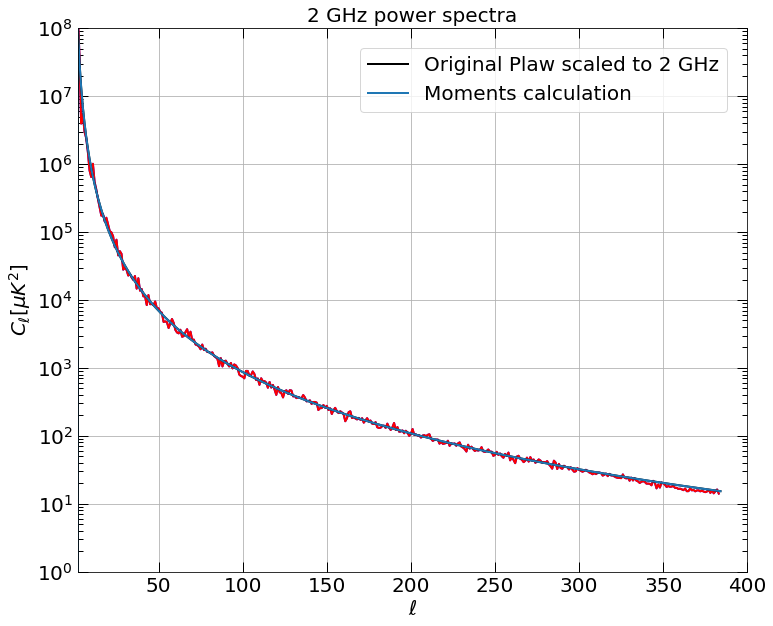

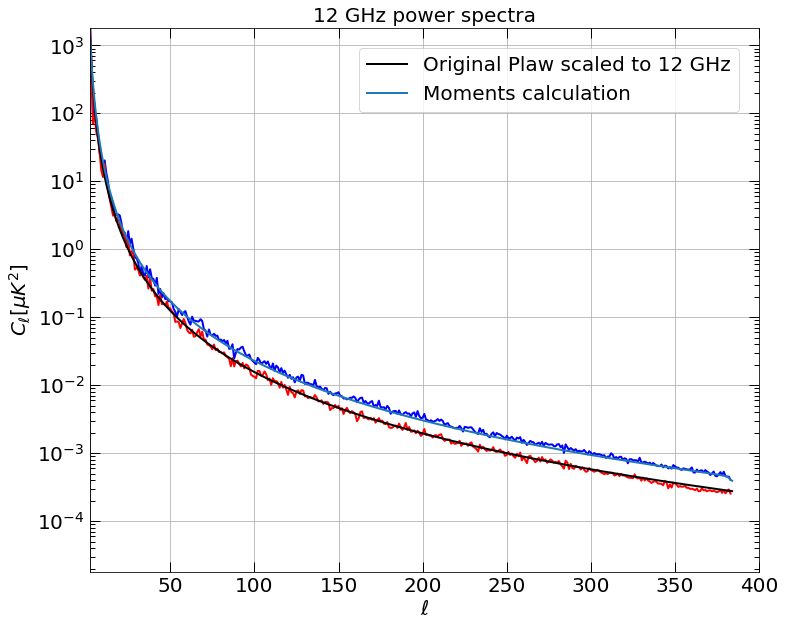

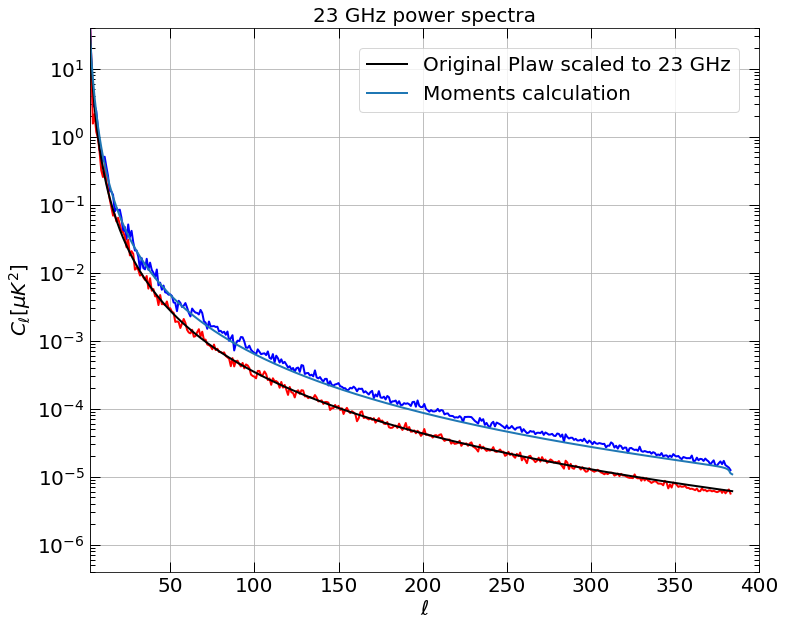

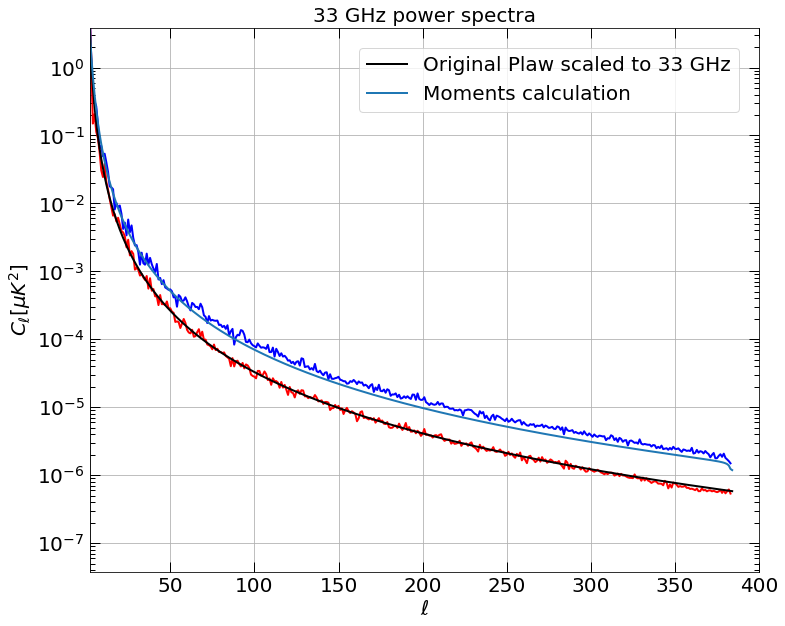

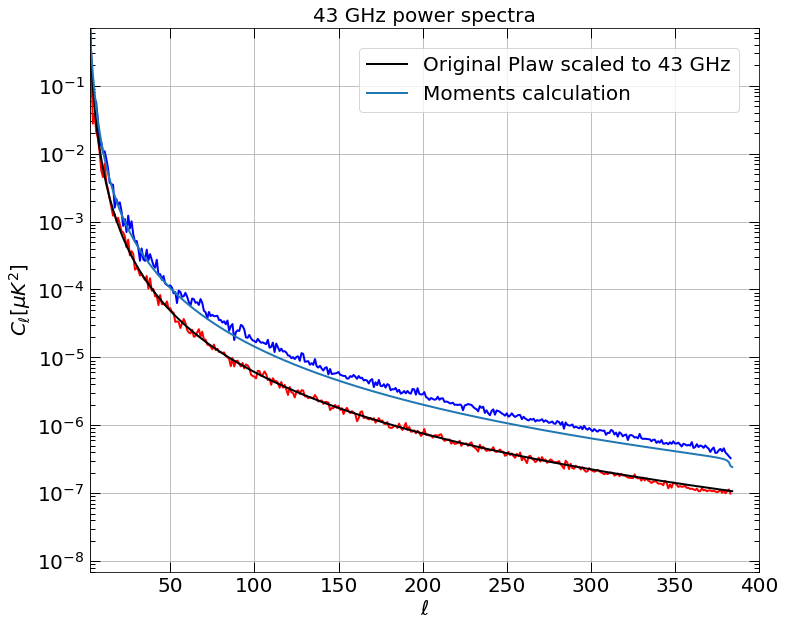

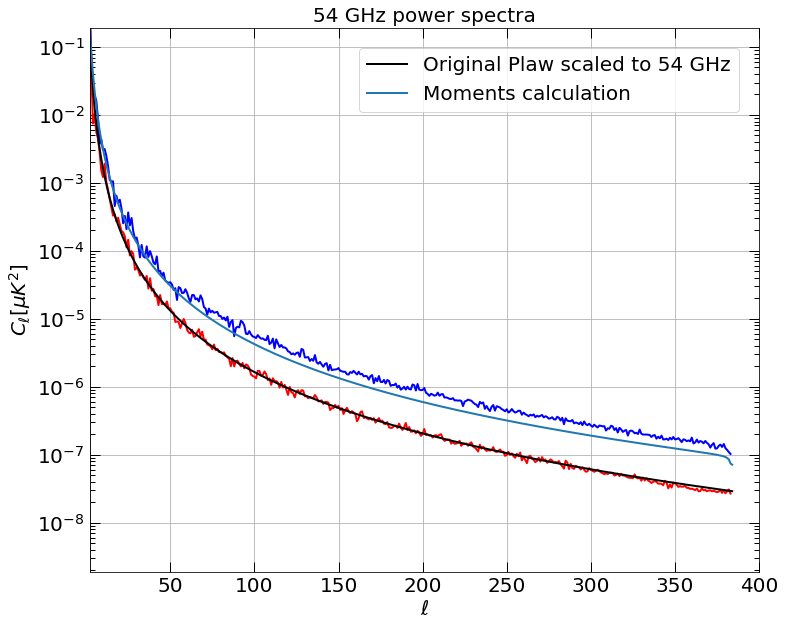

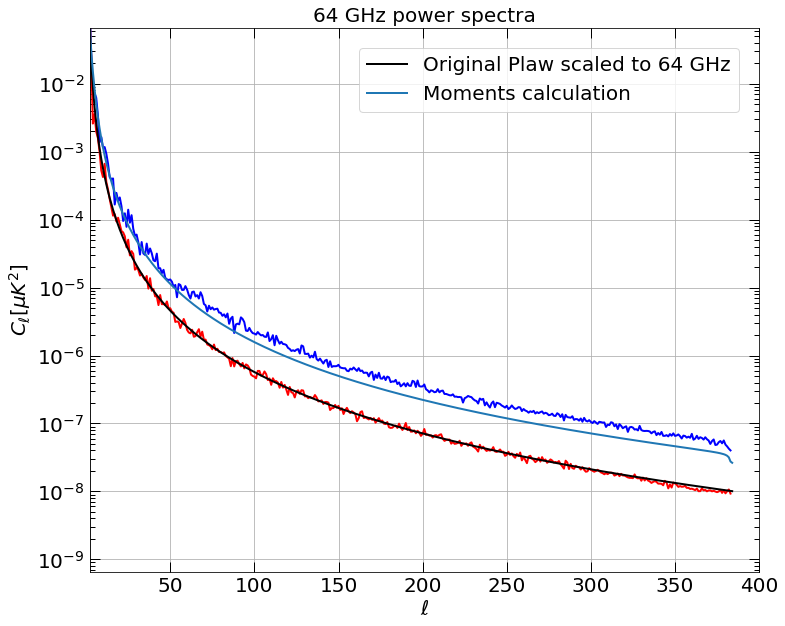

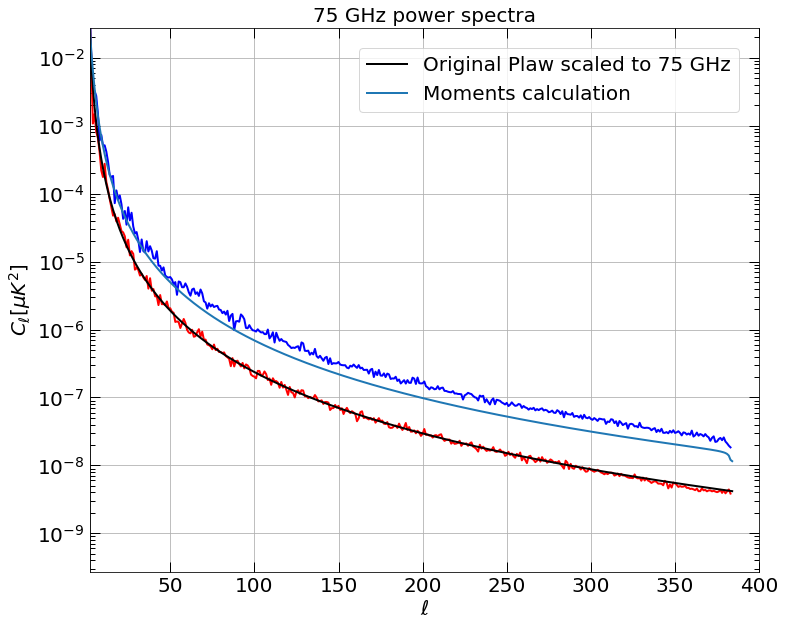

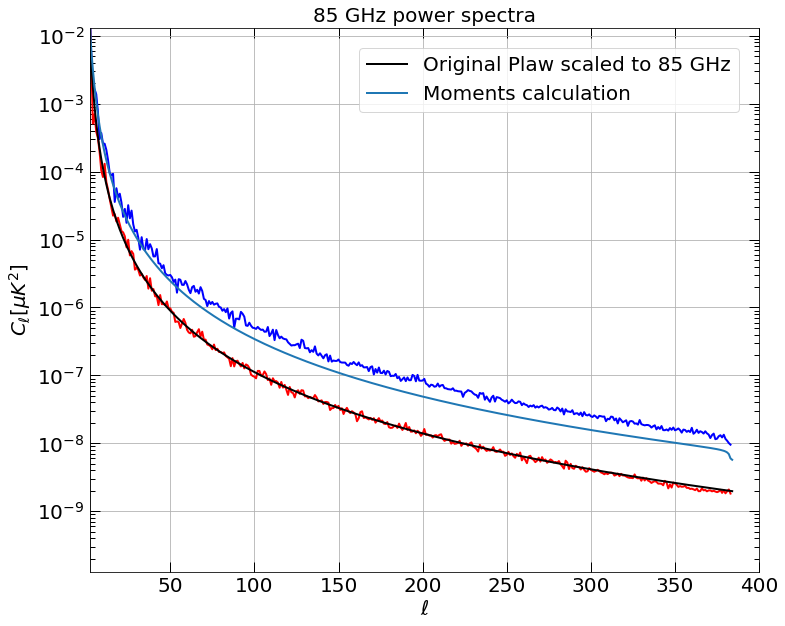

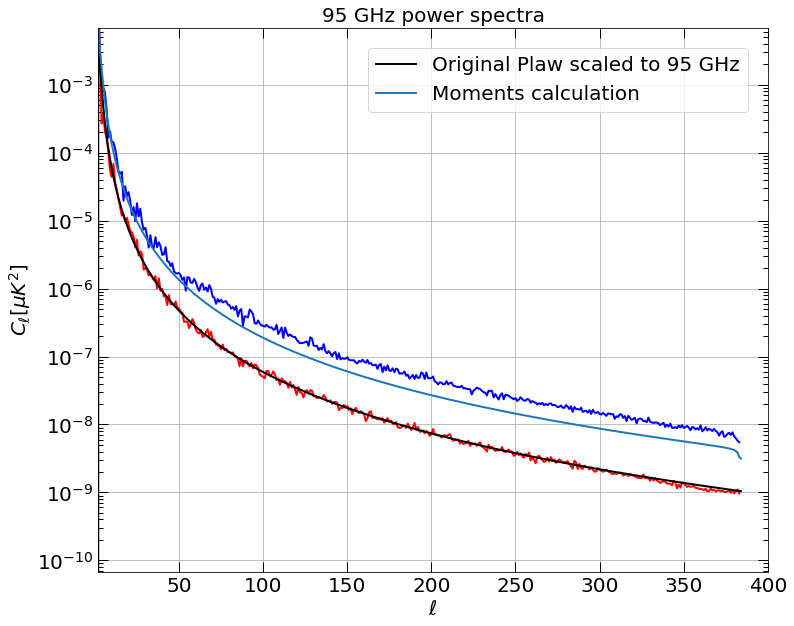

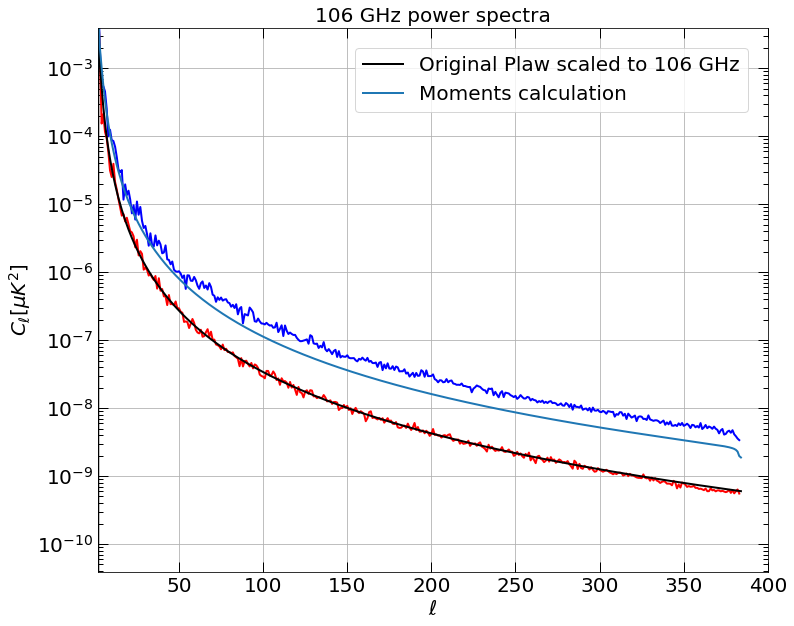

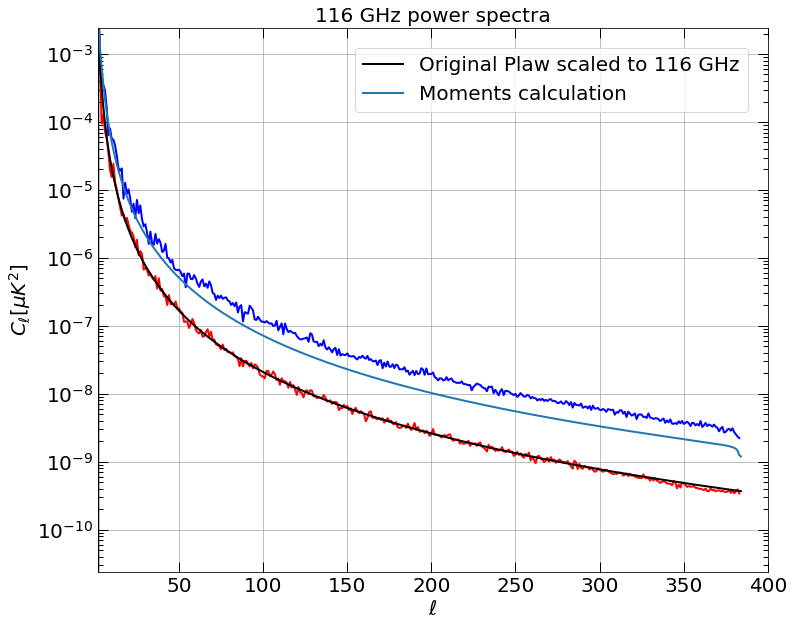

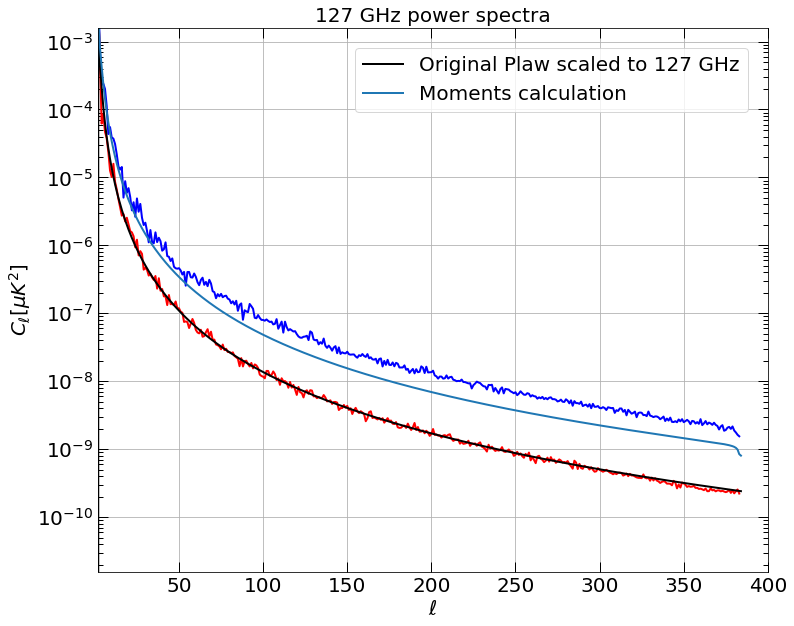

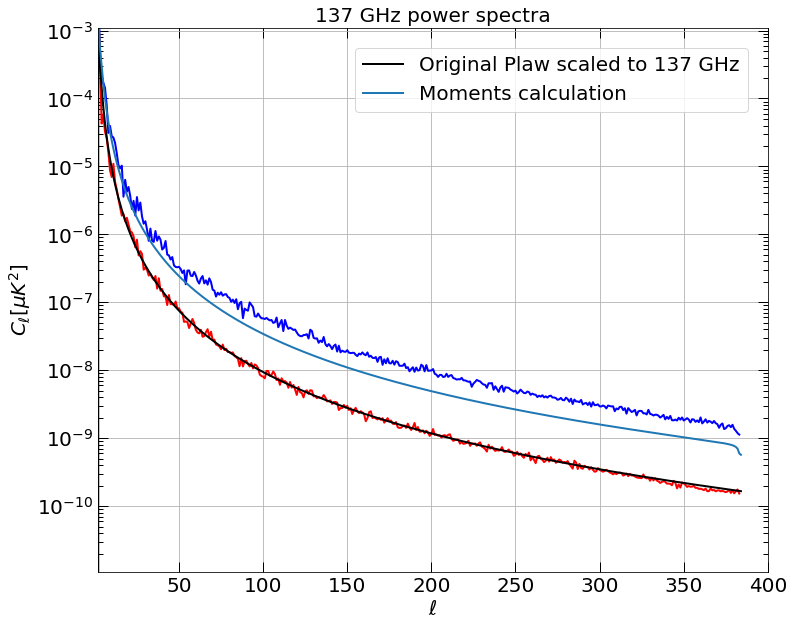

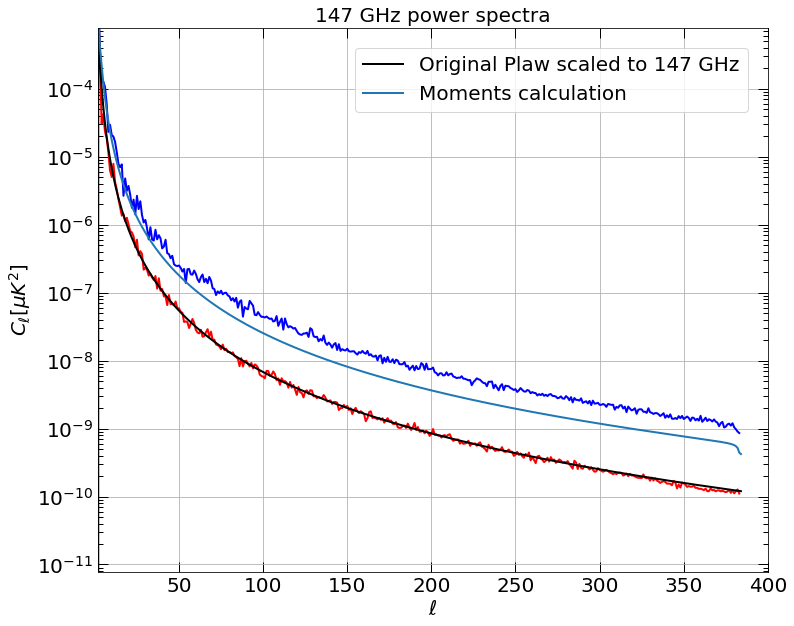

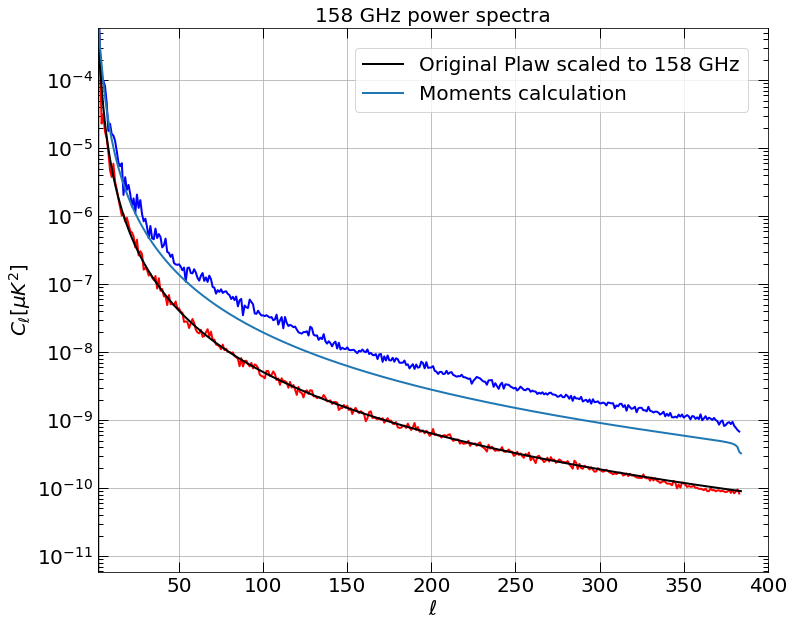

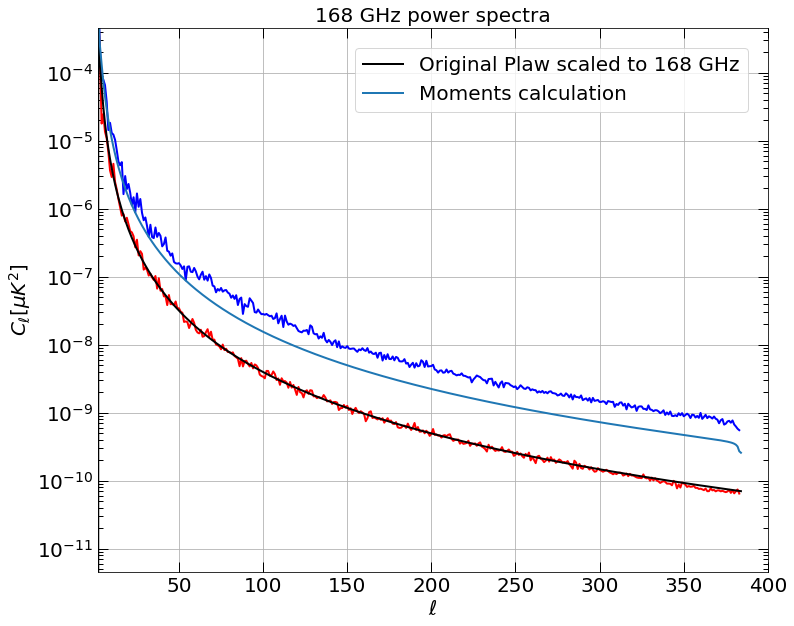

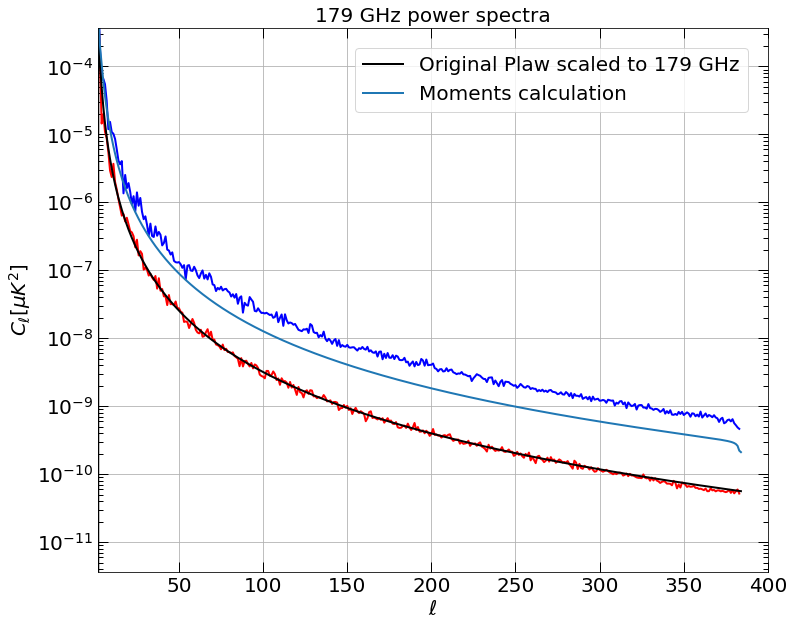

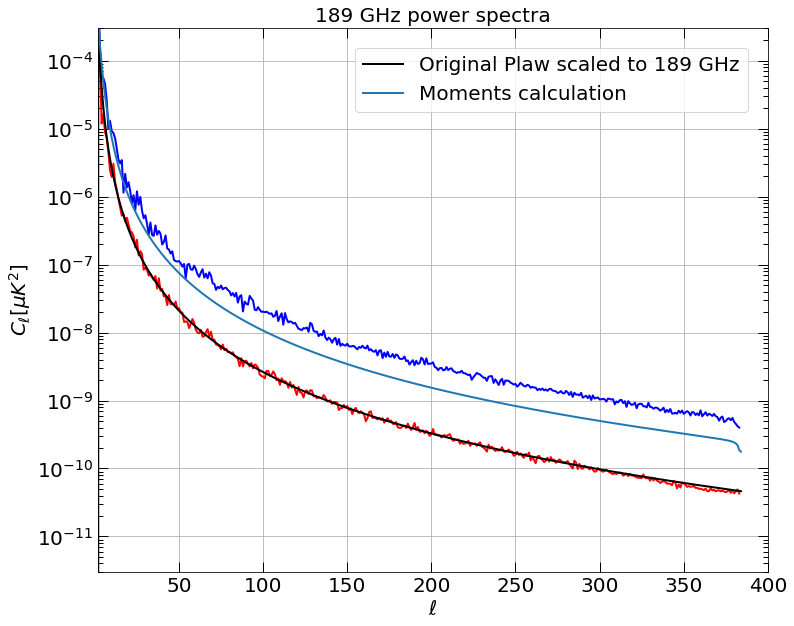

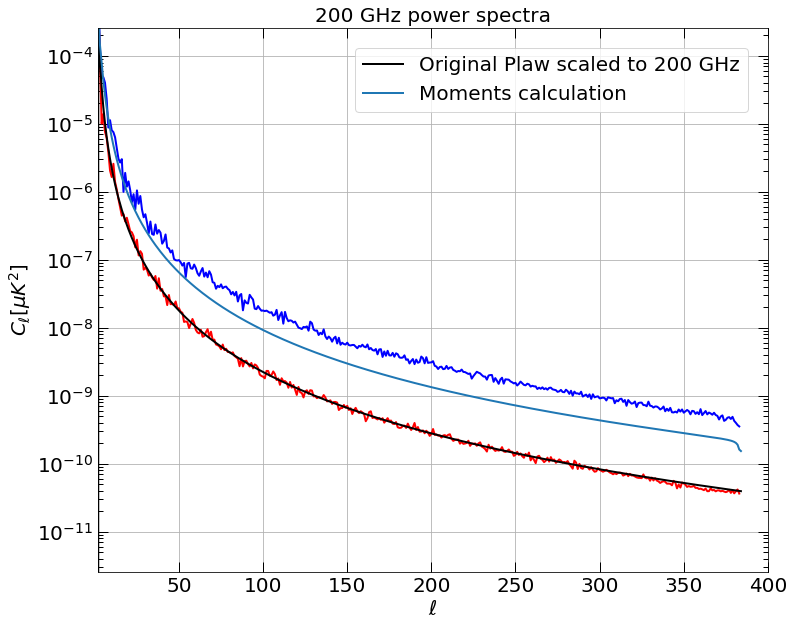

In [149]:
for k in range(20):
    figure()
    newcls = hp.anafast(x[k])
    oldcls = hp.anafast(newmaps[k])
    semilogy(newcls, 'b')
    semilogy(oldcls, 'r')
    semilogy(ells, pcls*sed_scaling[k]**2, label='Original Plaw scaled to %d GHz' 
             %int(freqs[k]*1e-9), color='k')
    moment1x1 = log(freqs[k]/nu0)**2 * sed_scaling[k]**2 * total[:385] * A_BB 
    #semilogy(ells, moment1x1, label='1x1 moment')
    semilogy(ells, moment1x1 + pcls*sed_scaling[k]**2 + moment0x2[k], label='Moments calculation')
    xlim(2, 400)
    ylim(1*sed_scaling[k]**2, 1e8*sed_scaling[k]**2)
    legend(loc=1)
    grid()
    ylabel("$C_{\ell} [\mu K^2]$")
    xlabel("$\ell$", fontsize=20)
    title('%d GHz power spectra' %int(freqs[k]*1e-9))